<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/rear_truncated_lstm_ae_(1_layer)_viridae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras

# Read Data

In [2]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/viridae/'
filename = 'clean.csv'
records_df = pd.read_csv(data_path + filename)
# replace all '-' with N (stands for any nt)
records_df.seq = records_df.seq.str.replace('-', 'N')
print(len(records_df))
records_df.head()

281


,id,seq,label
0,NC_036588.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
1,NC_014412.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
2,NC_014413.1,GNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
3,NC_025890.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
4,NC_023162.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0


In [13]:
records_df.seq = records_df.seq.str.replace('R', 'A')
records_df.seq = records_df.seq.str.replace('Y', 'T')

In [4]:
seq_len = len(records_df.seq[0])
seq_len

4132

In [14]:
# extract only first 2449 nts
length = 2449
records_df.seq = records_df.seq.str[:length]
seq_len = len(records_df.seq[0])
seq_len

2449

In [9]:
def n_gram(x, word_size=3):
  arr_x = [c for c in x]
  words = tf.strings.ngrams(arr_x, ngram_width=word_size, separator='').numpy()
  words = list(pd.Series(words).apply(lambda b: b.decode('utf-8')))
  return words

In [10]:
records_df["ngram"] = records_df.seq.apply(n_gram)
records_df.head()

,id,seq,label,ngram
0,NC_036588.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."
1,NC_014412.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."
2,NC_014413.1,GNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[GNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."
3,NC_025890.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."
4,NC_023162.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
xtrain_full, xtest, ytrain_full, ytest = train_test_split(records_df, records_df.label, test_size=0.2, random_state=100, stratify=records_df.label)
xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

shape of training, validation, test set
 (179, 3) (45, 3) (57, 3) (179,) (45,) (57,)


In [16]:
word_size = 1
bp_list = 'ACGTN'
vocab = [''.join(p) for p in product(bp_list, repeat=word_size)]
# word_to_idx = {word: i for i, word in enumerate(vocab)}
vocab_size = len(bp_list)
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 5


In [17]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, x_index
xtrain_seq = tf.data.Dataset.from_tensor_slices(xtrain['seq']).map(index_preprocess).batch(32)
xval_seq = tf.data.Dataset.from_tensor_slices(xval['seq']).map(index_preprocess).batch(32)
xtest_seq = tf.data.Dataset.from_tensor_slices(xtest['seq']).map(index_preprocess).batch(32)

In [18]:
latent_size = 256

encoder = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
])

decoder = keras.Sequential([
    keras.layers.RepeatVector(seq_len, input_shape=[latent_size]),
    keras.layers.LSTM(latent_size, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(5, activation='softmax'))  # ACTGN
])

recurrent_ae = keras.Sequential([encoder, decoder])
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256)               1152256   
_________________________________________________________________
sequential_1 (Sequential)    (None, 2449, 5)           526597    
Total params: 1,678,853
Trainable params: 1,678,853
Non-trainable params: 0
_________________________________________________________________


In [19]:
checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks/models/lstm1_viridae_random.32.{epoch:04d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=False,
    save_freq=360)
es_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [20]:
recurrent_ae.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=1000, callbacks=[es_cb, model_checkpoint_callback])
ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=1000, callbacks=[es_cb])

Epoch 1/1000
6/6 [==============================] - 3s 446ms/step - loss: 0.9443 - accuracy: 0.9173 - val_loss: 0.5350 - val_accuracy: 0.8991
Epoch 2/1000
6/6 [==============================] - 2s 335ms/step - loss: 0.4093 - accuracy: 0.9173 - val_loss: 0.4624 - val_accuracy: 0.8991
Epoch 3/1000
6/6 [==============================] - 2s 339ms/step - loss: 0.4045 - accuracy: 0.9173 - val_loss: 0.4790 - val_accuracy: 0.8991
Epoch 4/1000
6/6 [==============================] - 2s 338ms/step - loss: 0.3983 - accuracy: 0.9173 - val_loss: 0.4612 - val_accuracy: 0.8991
Epoch 5/1000
6/6 [==============================] - 2s 332ms/step - loss: 0.3963 - accuracy: 0.9173 - val_loss: 0.4598 - val_accuracy: 0.8991
Epoch 6/1000
6/6 [==============================] - 2s 333ms/step - loss: 0.3957 - accuracy: 0.9173 - val_loss: 0.4617 - val_accuracy: 0.8991
Epoch 7/1000
6/6 [==============================] - 2s 334ms/step - loss: 0.3942 - accuracy: 0.9173 - val_loss: 0.4604 - val_accuracy: 0.8991
Epoch 

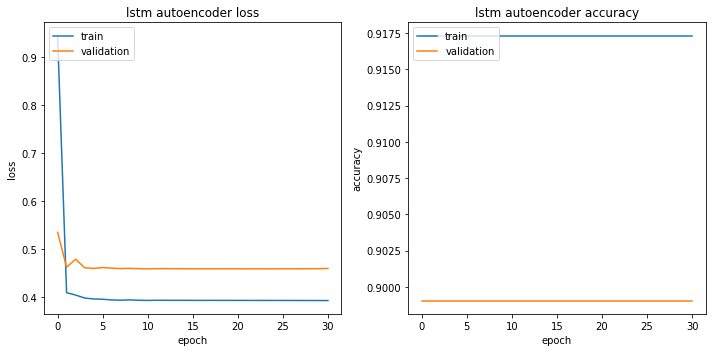

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(ae_hist.history['loss'], label='training')
  ax1.plot(ae_hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(ae_hist.history['accuracy'], label='training')
  ax2.plot(ae_hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [22]:
xtrain_vec = encoder.predict(xtrain_seq)
xval_vec = encoder.predict(xval_seq)
xtest_vec = encoder.predict(xtest_seq)
print('The shape of xtrain/xval/xtest_seq is', xtrain_vec.shape, xval_vec.shape, xtest_vec.shape)

The shape of xtrain/xval/xtest_seq is (179, 256) (45, 256) (57, 256)


In [23]:
def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
             cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

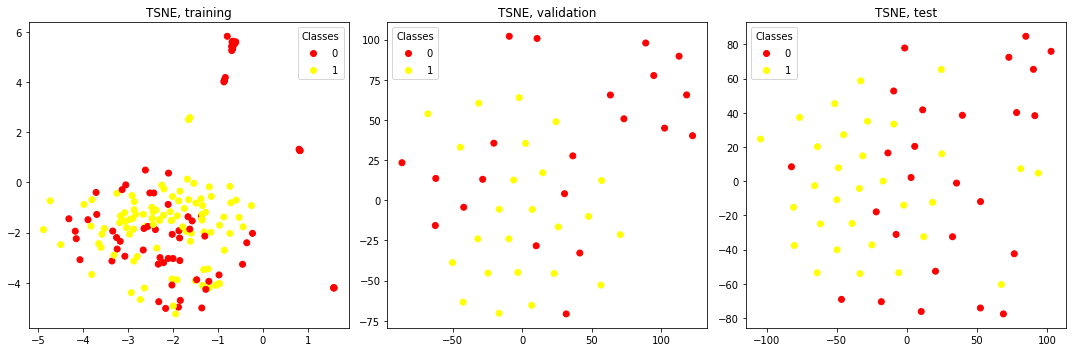

In [24]:
xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plotVec(axes[0], xtrain_tsne, ytrain, title="TSNE, training")
plotVec(axes[1], xval_tsne, yval, title="TSNE, validation")
plotVec(axes[2], xtest_tsne, ytest, title="TSNE, test")
fig.tight_layout()

In [25]:
model = keras.models.Sequential([
  keras.layers.Dense(256, activation="relu", input_shape=[latent_size]),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(64, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(32, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(16, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(1, activation="sigmoid")                               
])
model.compile(keras.optimizers.SGD(momentum=0.9), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model_hist = model.fit(xtrain_vec, ytrain, validation_data=(xval_vec, yval), epochs=50, callbacks=[es_cb])

Epoch 1/50
6/6 [==============================] - 0s 26ms/step - loss: 0.6950 - accuracy: 0.4972 - val_loss: 0.6897 - val_accuracy: 0.5333
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.4972 - val_loss: 0.6875 - val_accuracy: 0.5333
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5084 - val_loss: 0.6852 - val_accuracy: 0.5333
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.5307 - val_loss: 0.6825 - val_accuracy: 0.5333
Epoch 5/50
6/6 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5419 - val_loss: 0.6801 - val_accuracy: 0.5333
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5363 - val_loss: 0.6785 - val_accuracy: 0.5333
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 0.6808 - accuracy: 0.5419 - val_loss: 0.6770 - val_accuracy: 0.5333
Epoch 8/50
6/6 [=================

In [27]:
def eval_model(model, x, true_label, ds_name="Training"):
  loss, acc = model.evaluate(x, true_label, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}".format(ds_name, np.round(loss, 3), np.round(acc, 3)))

In [28]:
eval_model(model, xtrain_vec, ytrain, "Training")
eval_model(model, xval_vec, yval, "Validation")
eval_model(model, xtest_vec, ytest, "Test")

Training Dataset: loss = 0.629 and acccuracy = 0.676
Validation Dataset: loss = 0.61 and acccuracy = 0.711
Test Dataset: loss = 0.644 and acccuracy = 0.667


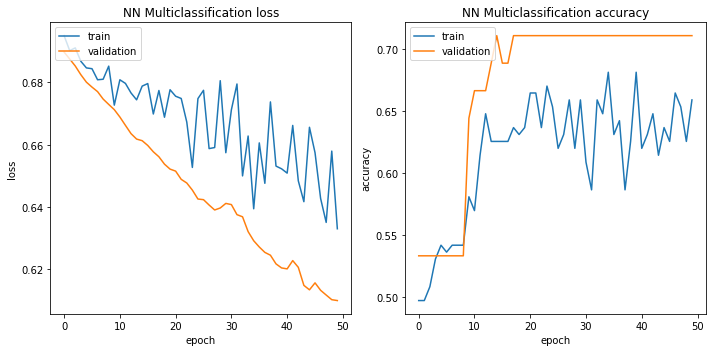

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(model_hist.history['loss'], label='training')
  ax1.plot(model_hist.history['val_loss'], label='validation')
  ax1.set_title('NN Multiclassification loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(model_hist.history['accuracy'], label='training')
  ax2.plot(model_hist.history['val_accuracy'], label='validation')
  ax2.set_title('NN Multiclassification accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()